# Hourly clustering over whole year 2024

In [23]:
import polars as pl
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import re
import pandas as pd

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation
from cluster_statistics import plot_cluster_percentiles
from Hyperparameters_KMeans import optimize_kmeans


## Data extraction and preprocessing

In [24]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")
output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")
output_folder.mkdir(parents=True, exist_ok=True)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess(df):
    # Parse the timestamp column (assuming 'timestamp' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    # Group by time_of_day across all days in the range and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    
    return day_avg

def normalize(df):  
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

for file_path in file_paths:
    df = pl.read_csv(file_path)
    time_avg = day_avg_preprocess(df)
    time_avg = normalize(time_avg)
    
    filename = os.path.basename(file_path)  # Original file name
    output_file = output_folder / filename  # Output path with same filename
    
    time_avg.write_csv(output_file)

## Data Clustering

In [25]:


input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

In [36]:

key_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)
#['tenant type', 'age', 'monthly income', 'education level', 'employment status']
# Now columns 10 and 131 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 142]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'Building Type']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_house_ids = extracted_df_pl["house-id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique house-id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['house-id'].map(mapping)

# Drop rows where 'Building Type' is 'House'
category_df = extracted_df.copy()
category_df = category_df[category_df['Building Type'] != 'Flat']
category_df = category_df[category_df['Building Type'] != 'No Information']

category_df = category_df.drop(columns=['Building Type'])
category_df = category_df.drop(columns=['house-id'])

print(category_df.head())




Total rows: 1500
Unique house-id count: 1500
No duplicates found in house_id column.
                                CH_id
0   CH1018601234500000000000000106795
9   CH1018601234500000000000000022206
10  CH1018601234500000000000000026700
11  CH1018601234500000000000000068376
12  CH1018601234500000000000000057886


In [37]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if pattern.search(os.path.basename(file_path)).group(1) in category_df['CH_id'].values:  
        if len(df) == n_timestamps:
            values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
            data_list.append(values_array)
            
            base = os.path.basename(file_path)
            match = pattern.search(base)
            if match:
                filename_list.append(match.group(1))
            else:
                filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

#print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d

#print(train_data)


Shape of the 3D array: (476, 96, 1)


# Validation Metric
Default runs Davies-Bouldin, Silhoutte score and Calinski Harabasz scores can be plotted by uncommenting few lines

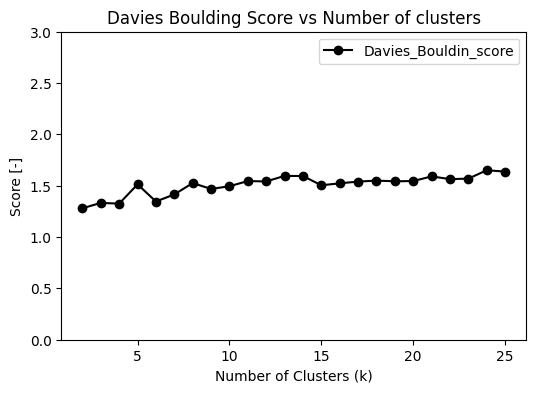

1.2804003241912574

Best combination of hyperparameters:
n_clusters                  4
init                k-means++
n_init                      3
max_iter                  500
silhouette_score     0.229017
db_score             1.285636
Name: 39, dtype: object


n_clusters                  4
init                k-means++
n_init                      3
max_iter                  500
silhouette_score     0.229017
db_score             1.285636
Name: 39, dtype: object

In [38]:
validation(train_data)

optimize_kmeans(train_data)

# K-means Clustering
change n_clusters as required

In [39]:
n_clusters = 3  # Number of clusters, you can adjust this
max_iterations =200
n_init = 3

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=False, random_state=42,n_init=n_init, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

print(clusters_train)

[2 1 2 0 0 2 0 1 1 0 1 2 0 0 0 2 2 0 2 0 0 1 0 0 2 0 0 2 0 0 0 0 0 2 1 2 2
 1 0 1 0 1 0 2 1 0 0 2 1 1 2 2 0 1 1 2 1 1 1 2 0 1 2 1 2 1 2 2 2 1 0 2 0 2
 2 0 2 2 2 0 0 2 2 0 1 0 2 0 1 1 1 1 2 1 0 0 0 0 1 0 1 0 0 1 0 2 1 1 2 1 0
 0 1 0 2 0 1 2 2 1 0 2 1 0 0 2 1 1 1 0 1 0 1 2 1 0 0 1 2 0 2 2 0 1 0 0 0 1
 0 0 1 2 0 1 0 0 2 0 2 1 0 0 1 0 0 1 0 1 2 1 0 0 1 1 1 2 2 0 2 1 2 1 1 0 2
 0 1 0 0 0 1 0 2 0 1 2 2 0 0 1 1 0 1 0 1 1 0 2 0 1 1 0 0 2 0 1 0 2 2 0 0 1
 1 2 0 1 1 0 1 1 0 0 2 0 1 2 0 2 0 1 1 1 2 2 0 0 0 2 1 2 2 0 1 0 0 1 2 0 1
 1 0 1 2 1 2 1 2 0 0 2 1 1 2 0 0 0 1 1 0 0 0 2 2 0 1 0 0 0 0 1 1 1 0 0 0 0
 1 2 1 1 0 0 0 0 2 1 0 0 0 0 0 0 0 2 0 2 2 1 0 0 2 2 2 0 1 0 1 0 1 0 0 0 2
 0 0 1 1 1 1 0 2 0 1 1 0 2 1 0 1 2 1 2 1 1 0 1 0 1 0 0 0 0 0 0 2 1 0 0 0 2
 2 1 0 1 0 1 0 0 1 2 1 2 1 2 0 0 2 2 0 1 0 2 0 0 0 0 1 0 2 1 2 0 0 2 2 0 2
 1 0 2 0 1 0 2 0 2 0 1 0 1 1 2 0 2 0 0 2 1 1 0 2 2 2 2 0 2 0 0 1 1 1 1 0 1
 2 0 2 0 0 1 0 0 0 0 1 1 1 0 2 0 0 1 0 0 0 2 0 0 0 0 0 1 0 0 2 2]


# Plotting the cluster average patterns

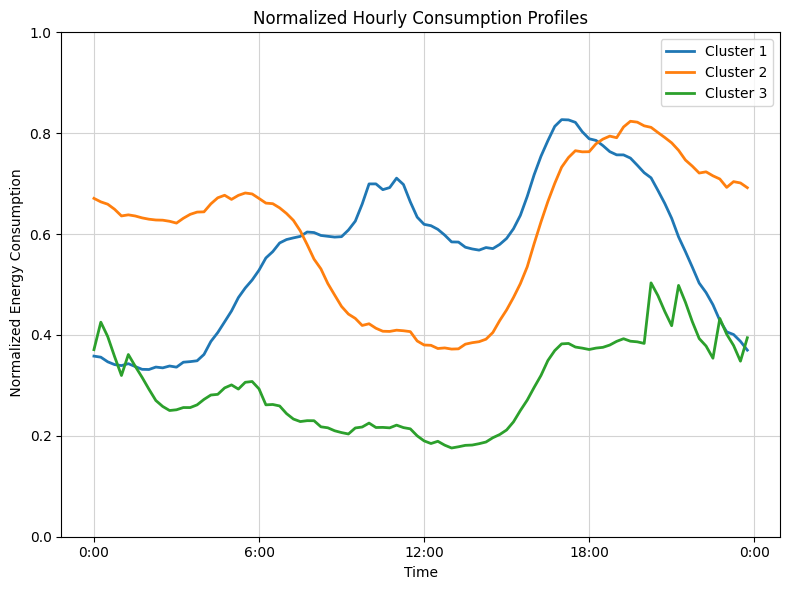

In [40]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'Cluster {cluster_no}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title(f'Normalized Hourly Consumption Profiles')
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    plt.grid(True, color = 'lightgray')
    plt.legend(
    loc='upper right',
    bbox_to_anchor=(1, 1),
    ncol=1,
    fontsize='medium'
)
    plt.savefig(
    "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/HourlyAveraged_Clusters.png",
    bbox_inches='tight'
    )
    plt.show()

plot_clusters_season()

## Actual energy consumption of each cluster

In [41]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")

result_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Cluster/hourly_avg_clustering.csv")



In [42]:


# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = round(result_df["bruttolastgang_kwh_sum"].mean(),2)
overall_seasonal_avg = round(result_df['average_daily_consumption'].mean(),2)

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Combined"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "avg_daily_consumption [kWh]": [overall_seasonal_avg]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (4, 4)
┌──────────┬────────────────┬──────────────────────────────┬─────────────────────────────┐
│ cluster  ┆ num_households ┆ avg_yearly_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---      ┆ ---            ┆ ---                          ┆ ---                         │
│ str      ┆ u32            ┆ f64                          ┆ f64                         │
╞══════════╪════════════════╪══════════════════════════════╪═════════════════════════════╡
│ 1        ┆ 210            ┆ 6371.28                      ┆ 11.15                       │
│ 2        ┆ 145            ┆ 9615.24                      ┆ 15.2                        │
│ 3        ┆ 121            ┆ 9076.03                      ┆ 14.63                       │
│ Combined ┆ 476            ┆ 8047.01                      ┆ 13.27                       │
└──────────┴────────────────┴──────────────────────────────┴─────────────────────────────┘


### Plotting the clusters in separate plots

Cluster 1: PAR =' 1.46' 


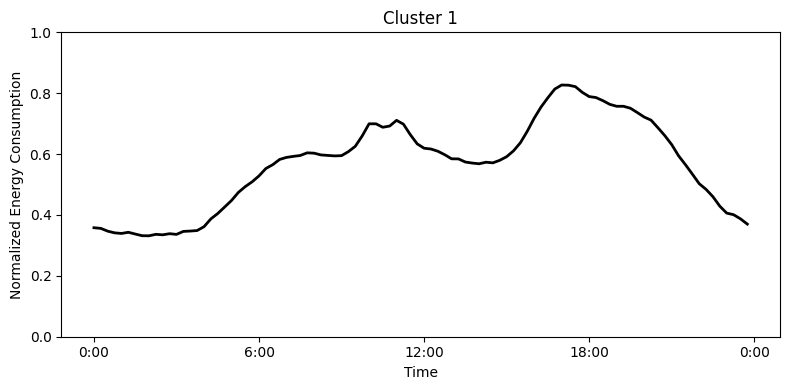

Cluster 2: PAR =' 1.36' 


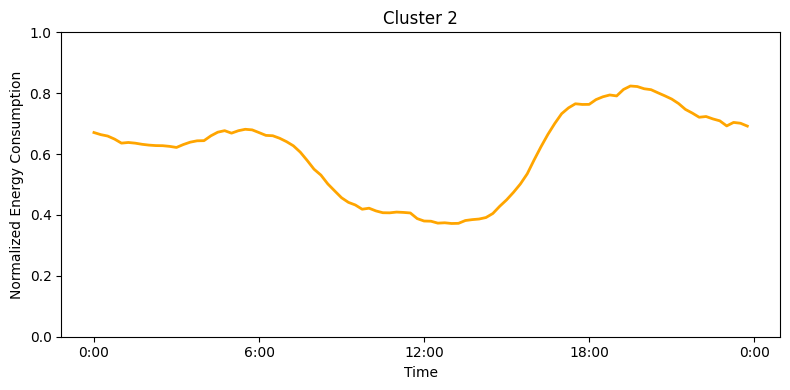

Cluster 3: PAR =' 1.69' 


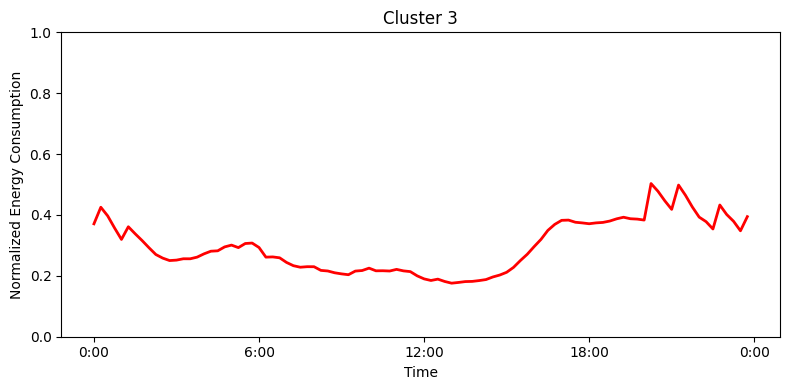

In [43]:
# Calculate and plot the average pattern for each cluster
save = 0 #if you want to save the plots

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['black','orange','red','green','lightgrey','pink','darkgrey','darkblue','blue','indianred','purple','magenta','pink','violet']

for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)
    print(f"Cluster {cluster_idx+1}: PAR =' {PAR_max/PAR_average:.2f}' ")
    
    # Plot the mean time series
    plt.figure(figsize=(8, 4))
    
    plt.plot(range(1,97), mean_time_series.ravel()[:96], 
             label= f'Mean Time Series \n No. of Time Series: {len(cluster_indices)}',
               linewidth =2, color= colors[cluster_idx] )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0,1)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()


### Plotting Mean, Median and percentiles of the clusters

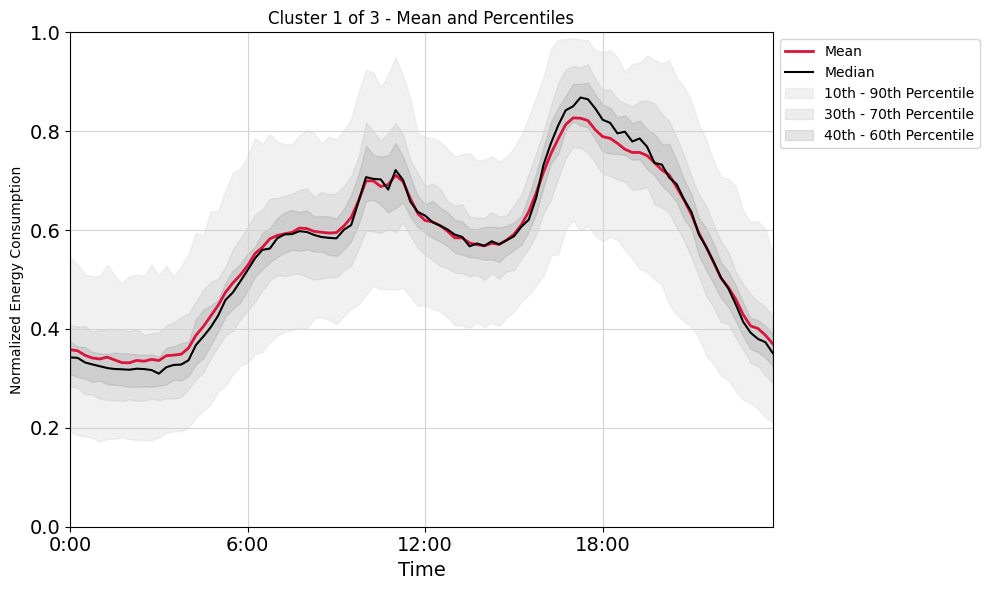

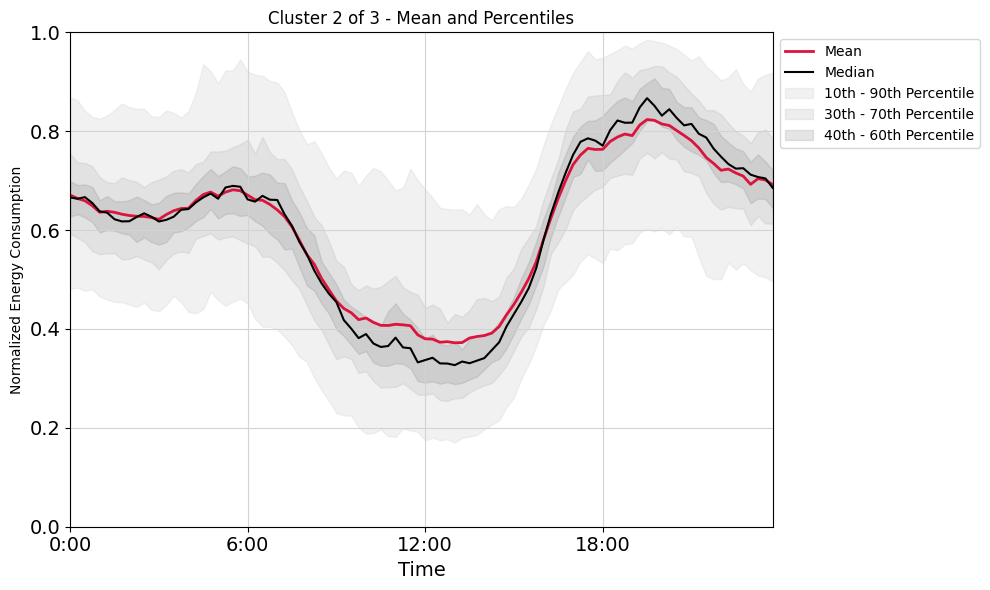

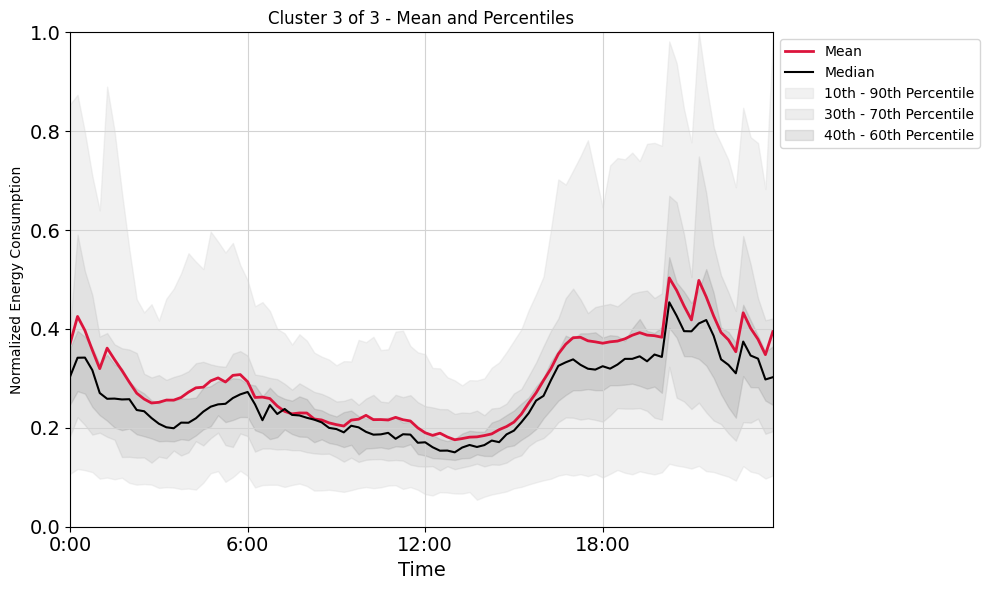

shape: (96, 6)
┌────────────────┬────────────────┬────────────────┬───────────────┬───────────────┬───────────────┐
│ lower_percenti ┆ lower_percenti ┆ lower_percenti ┆ upper_percent ┆ upper_percent ┆ upper_percent │
│ le_cluster_1   ┆ le_cluster_2   ┆ le_cluster_3   ┆ ile_cluster_1 ┆ ile_cluster_2 ┆ ile_cluster_3 │
│ ---            ┆ ---            ┆ ---            ┆ ---           ┆ ---           ┆ ---           │
│ f64            ┆ f64            ┆ f64            ┆ f64           ┆ f64           ┆ f64           │
╞════════════════╪════════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 0.192218       ┆ 0.481126       ┆ 0.106948       ┆ 0.543575      ┆ 0.868408      ┆ 0.854717      │
│ 0.185214       ┆ 0.483527       ┆ 0.116904       ┆ 0.530668      ┆ 0.862528      ┆ 0.873522      │
│ 0.182398       ┆ 0.477462       ┆ 0.11437        ┆ 0.510149      ┆ 0.841181      ┆ 0.7977        │
│ 0.18049        ┆ 0.480213       ┆ 0.110515       ┆ 0.507033      ┆ 0.82875

In [44]:
plot_cluster_percentiles(train_data, clusters_train, n_clusters)

print(train_data, clusters_train, n_clusters)

Cluster 1: PAR = 1.46
Cluster 2: PAR = 1.36
Cluster 3: PAR = 1.69
Cluster 4: PAR = nan


/opt/anaconda3/envs/MLDA/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MLDA/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


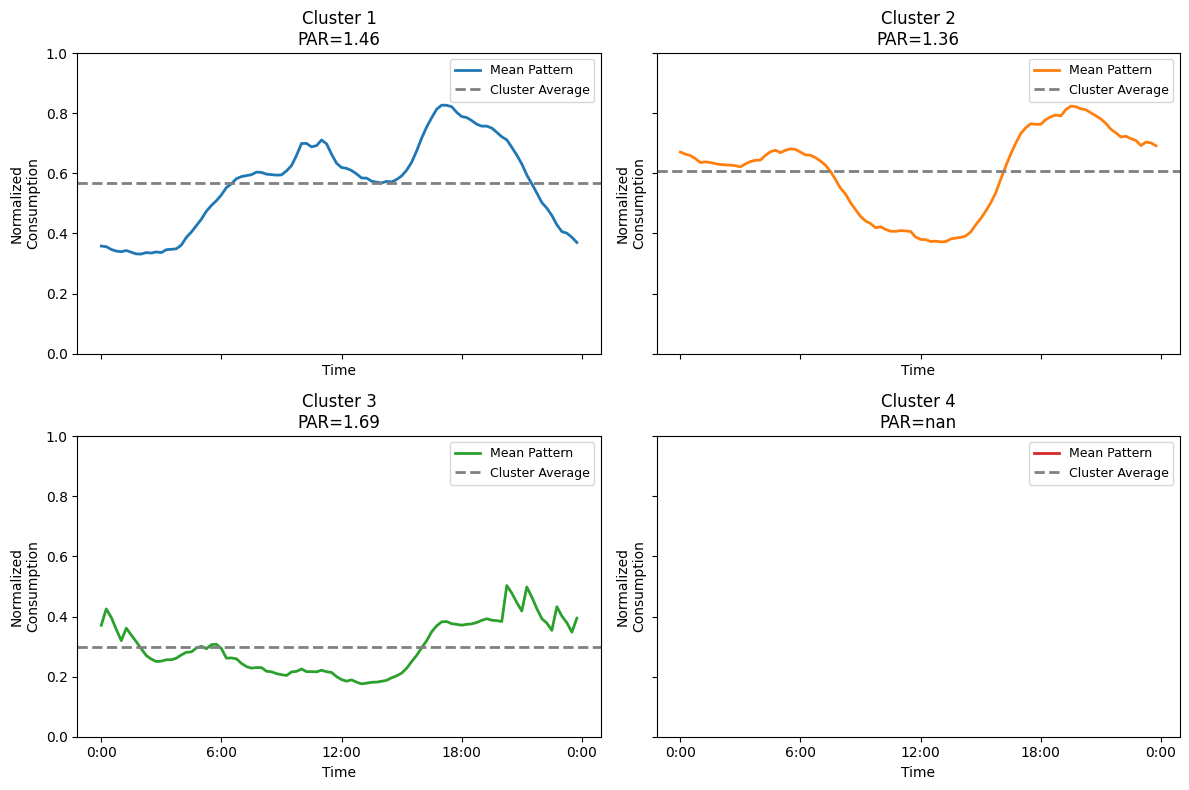

In [45]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

# Compute the mean time series and PAR for each cluster and store for subplot
mean_time_series_all = []
mean_lines = []

n_clusters_to_plot = 4
f, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
axs = axs.flatten()

for cluster_idx in range(n_clusters_to_plot):
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    

    mean_time_series = np.mean(cluster_data, axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)
    print(f"Cluster {cluster_idx+1}: PAR = {PAR_max/PAR_average:.2f}")

    # Individual plots (optional)
    
    # Subplot (2x2)
    ax = axs[cluster_idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96], 
                 label='Mean Pattern', linewidth=2, color=colors[cluster_idx])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cluster_idx+1}\nPAR={PAR_max/PAR_average:.2f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalized\nConsumption")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(1, 120, 24))
    ax.set_xticklabels(labels)
    ax.legend(fontsize=9)

plt.tight_layout()
    
plt.savefig(
"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/PAR_Kmeans.png",
bbox_inches='tight'
)
plt.show()